In [1]:
import sys
import os
sys.path.append(os.getcwd())

%load_ext autoreload
%autoreload 2

# Import 

In [31]:
from pathlib import Path
import numpy as np
from tqdm import tqdm
import trimesh
import open3d as o3d
import yaml
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from copy import deepcopy

import polyscope as ps

from src.mesh_io import trimesh_to_o3d, normalize_mesh_with_transform, o3d_to_pymeshlab, pymeshlab_to_o3d
from src.utils import print_tensor, find_objects, get_render, get_prim_mesh_path
from src.macro import prim_color_to_name, prim_name_to_id
from src.forensics import analyze_mesh, quick_plots, mesh_arrays
from src.deformation import trellis_like_deform, spectral_displacement
from src.visu import PolyscopeSession

# Setup

In [3]:
DATA_DIR_GT = Path("data/gt_meshes/20251114_134358-gt_meshes-07-pipeline_65k/segmented_meshes")
DATA_DIR_GEN = Path("data/gen_meshes/20251114_131205-gen_meshes_pure_planes-02-pipeline_LN_encoderFrozen/segmented_meshes")

sha_list_gt = find_objects(DATA_DIR_GT)
print(f"Found {len(sha_list_gt)} objects in {DATA_DIR_GT}")
sha_list_gen = find_objects(DATA_DIR_GEN)
print(f"Found {len(sha_list_gen)} objects in {DATA_DIR_GEN}")
assert set(sha_list_gt) == set(sha_list_gen), "GT and GEN object sets do not match!"
sha_list = sha_list_gt
del sha_list_gt, sha_list_gen

# with open("data/asset_ids.txt", 'w') as f:
#     for s in sorted(sha_list):
#         f.write(f"{s}\n")

Found 100 objects in data\gt_meshes\20251114_134358-gt_meshes-07-pipeline_65k\segmented_meshes
Found 100 objects in data\gen_meshes\20251114_131205-gen_meshes_pure_planes-02-pipeline_LN_encoderFrozen\segmented_meshes


# Load a mesh

Analyzing object f4559de0f094665cc80f9df90f60f5654c5cfad1595a94ac2f95e7f74b295e35


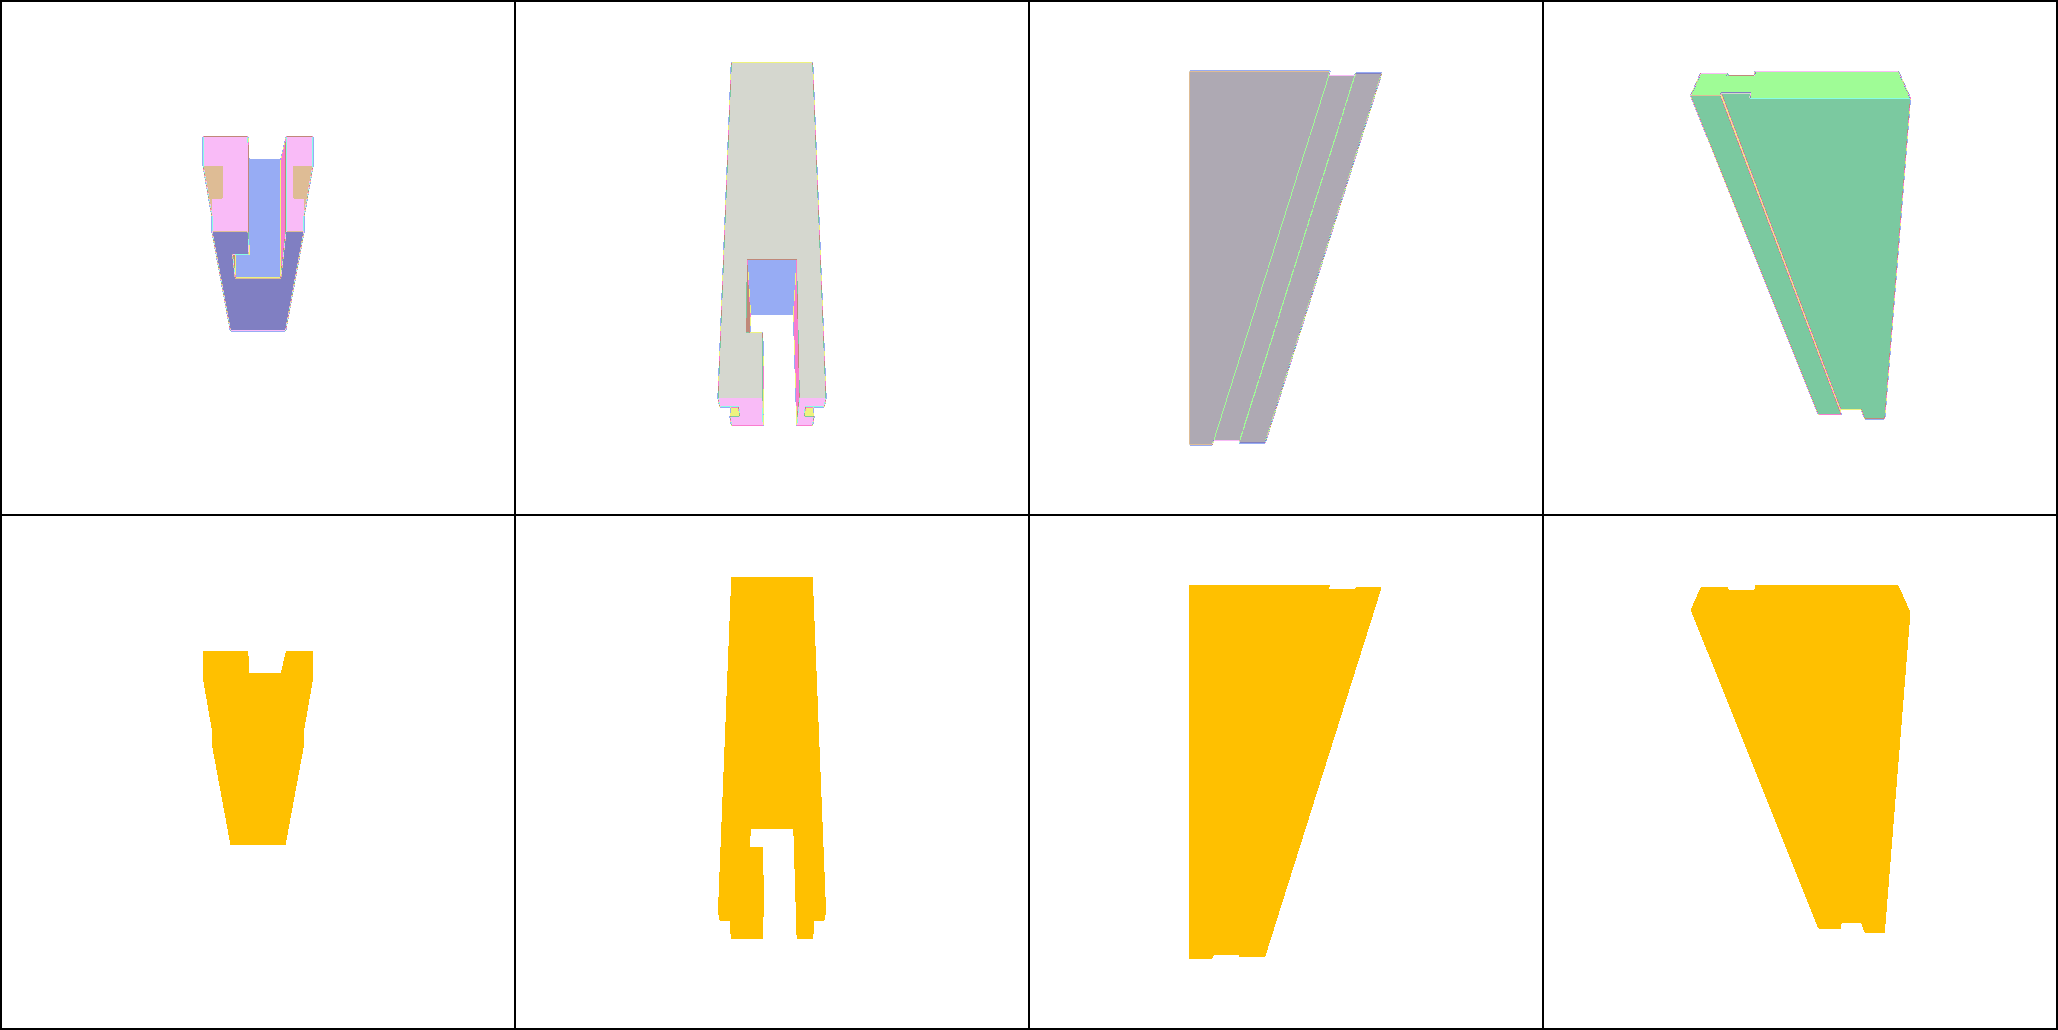

In [62]:
sha = np.random.choice(sha_list)
print(f"Analyzing object {sha}")
get_render(sha)

In [340]:
sha = "9e0362d1427678d1f8dd2001231cb036eaa7ba87a97a0897cc2e97632c050113"
mesh_path = get_prim_mesh_path(sha, version='gt')

mesh_tm = trimesh.load(mesh_path, process=False, force='mesh')
tri_prim_labels = np.array([prim_name_to_id(prim_color_to_name(c)) for c in mesh_tm.visual.face_colors[:, :3]])

print_tensor(mesh_tm.vertices, 'vertices')
print_tensor(mesh_tm.faces, 'faces')
print_tensor(tri_prim_labels, 'Primitive Labels')

vertices             : (24, 3), min : -271.820, max : 204.173, mean : 22.293, std : 156.056
faces                : (44, 3), min : 0.000, max : 23.000, mean : 11.500, std : 6.907
Primitive Labels     : (44,), min : 0.000, max : 0.000, mean : 0.000, std : 0.000


# Analyze mesh

In [122]:
from src.forensics import compute_edge_data

In [120]:
# Forensics on original CAD
mesh_o3d = trimesh_to_o3d(mesh_tm)
summary_cad = analyze_mesh(mesh_o3d, face_labels=tri_prim_labels)


In [165]:
uniq_edges, edge_face_indices = compute_edge_data(mesh_o3d)


In [159]:
deg = np.array([len(faces) for faces in edge_face_indices])
np.unique(deg)

array([2])

In [158]:
# from src.forensics import mesh_arrays

# _, F = mesh_arrays(mesh_o3d)

# # Build all directed edges then uniq
# e01 = F[:, [0, 1]]
# e12 = F[:, [1, 2]]
# e20 = F[:, [2, 0]]
# edges = np.vstack([e01, e12, e20])
# face_ids = np.repeat(np.arange(F.shape[0]), 3)

# # sort endpoints so undirected edges deduplicate
# edges_sorted = np.sort(edges, axis=1)                                       # in this way, (i,j) == (j,i)
# uniq_edges, inv = np.unique(edges_sorted, axis=0, return_inverse=True)      # edge_sorted[k] maps to uniq_edges[inv[k]], e.g. 

edge_length:
  mean: 46.65450075900674
  std: 57.062415508316256
  min: 2.0
  max: 300.04166377354994
  p50: 20.615528128088304
  p90: 88.56635930193812
  p99: 300.0
triangle_aspect_ratio:
  mean: 13.961180234920949
  std: 16.711793856740744
  min: 1.9999999999999747
  max: 68.31842105260303
  p50: 4.24999999999933
  p90: 40.02499999998047
  p99: 65.74487719295908
vertex_curvature:
  mean: 25.147644599283154
  std: 28.7812665201415
  min: 2.8356333201827444
  max: 117.22243285921041
  p50: 16.57962133404316
  p90: 77.67980280669605
  p99: 112.01959474645798
planarity_rms:
  mean: 0.10149844798055754
  std: 0.21014092806083928
  min: 0.0
  max: 1.05587661433573
  p50: 0.0
  p90: 0.4899468058090211
  p99: 0.8028451355917056
dihedral_angle:
  mean: 71.54042084841849
  std: 58.181250777810305
  min: 8.102307404646514e-05
  max: 179.9999189679299
  p50: 90.0
  p90: 179.9999189679299
  p99: 179.9999189679299
per_primitive:
  0:
    curvature:
      mean: 25.147644599283154
      std: 28.7812

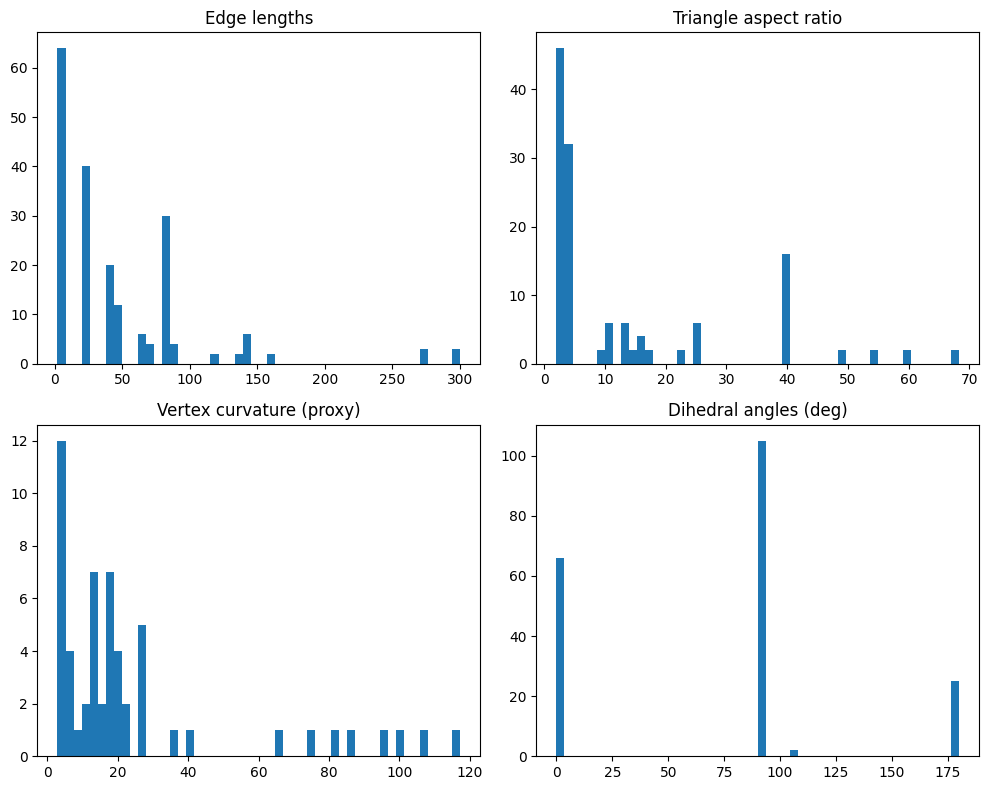

In [31]:
quick_plots(mesh_o3d)
print(yaml.dump(summary_cad, sort_keys=False))

In [ ]:
quick_plots(mesh)

### Curvature (proxy)

In [186]:
from src.forensics import vertex_curvatures
from src.mesh_io import normalize_mesh_with_transform

Analyzing object ea5629972071813279ea9cf4a2caa819fc961cb3bfaebf0b8d6c055434f9c749


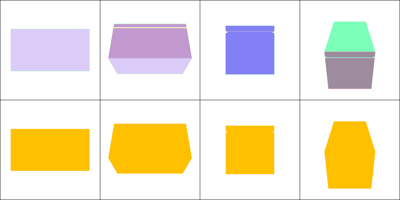

In [175]:
sha = "ea5629972071813279ea9cf4a2caa819fc961cb3bfaebf0b8d6c055434f9c749" # np.random.choice(sha_list)
print(f"Analyzing object {sha}")
get_render(sha).resize((400,200))

In [191]:
mesh_gt_path = get_prim_mesh_path(sha, version='gt')
mesh_gt = o3d.io.read_triangle_mesh(str(mesh_gt_path))
mesh_gt, _, _ = normalize_mesh_with_transform(mesh_gt)

mesh_gen_path = get_prim_mesh_path(sha, version='gen')
mesh_gen = o3d.io.read_triangle_mesh(str(mesh_gen_path))
mesh_gen, _, _ = normalize_mesh_with_transform(mesh_gen)

vc_gt = vertex_curvatures(mesh_gt)
vc_gen = vertex_curvatures(mesh_gen)

Text(0.5, 1.0, 'GEN Vertex Curvatures')

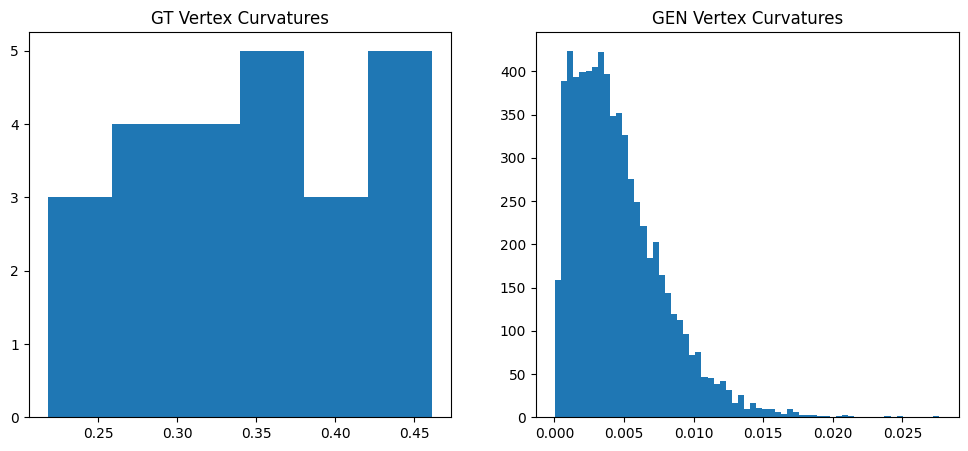

In [192]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].hist(vc_gt, bins='auto')
ax[0].set_title('GT Vertex Curvatures')
ax[1].hist(vc_gen, bins='auto')
ax[1].set_title('GEN Vertex Curvatures')

In [198]:
with PolyscopeSession() as ps_session:
	ps_gt_mesh = ps_session.register(ps.register_surface_mesh("gt_mesh", np.asarray(mesh_gt.vertices), np.asarray(mesh_gt.triangles)))
	ps_gt_mesh.add_scalar_quantity("vertex_curvatures", vc_gt, defined_on='vertices')

	ps_gen_mesh = ps_session.register(ps.register_surface_mesh("gen_mesh", np.asarray(mesh_gen.vertices), np.asarray(mesh_gen.triangles)))
	ps_gen_mesh.add_scalar_quantity("vertex_curvatures", vc_gen, defined_on='vertices')
	ps.show()

### Planarity score

In [201]:
from src.forensics import sample_points_uniform_trimesh, planarity_scores

In [204]:
mesh_gt_path = get_prim_mesh_path(sha, version='gt')
mesh_gt = o3d.io.read_triangle_mesh(str(mesh_gt_path))
mesh_gt, _, _ = normalize_mesh_with_transform(mesh_gt)
pts_gt, face_idx_gt = sample_points_uniform_trimesh(mesh_gt)
planarity_gt = planarity_scores(pts_gt)
print_tensor(planarity_gt, 'planarity_gt')

mesh_gen_path = get_prim_mesh_path(sha, version='gen')
mesh_gen = o3d.io.read_triangle_mesh(str(mesh_gen_path))
mesh_gen, _, _ = normalize_mesh_with_transform(mesh_gen)
pts_gen, face_idx_gen = sample_points_uniform_trimesh(mesh_gen)
planarity_gen = planarity_scores(pts_gen)
print_tensor(planarity_gen, 'planarity_gen')

planarity_gt         : (50000,), min : 0.000, max : 0.006, mean : 0.001, std : 0.001
planarity_gen        : (50000,), min : 0.000, max : 0.005, mean : 0.000, std : 0.001


In [210]:
planarity_max = max(planarity_gt.max(), planarity_gen.max())
planarity_min = min(planarity_gt.min(), planarity_gen.min())

with PolyscopeSession() as ps_session:
	ps_gt_mesh = ps_session.register(ps.register_surface_mesh("gt_mesh", np.asarray(mesh_gt.vertices), np.asarray(mesh_gt.triangles)))
	ps_pcd_gt = ps_session.register(ps.register_point_cloud("gt_points", np.asarray(pts_gt)))
	ps_pcd_gt.add_scalar_quantity("point_planarity", planarity_gt, vminmax=(planarity_min, planarity_max), cmap='jet')

	ps_gen_mesh = ps_session.register(ps.register_surface_mesh("gen_mesh", np.asarray(mesh_gen.vertices), np.asarray(mesh_gen.triangles)))
	ps_pcd_gen = ps_session.register(ps.register_point_cloud("gen_points", np.asarray(pts_gen)))
	ps_pcd_gen.add_scalar_quantity("point_planarity", planarity_gen, vminmax=(planarity_min, planarity_max), cmap='jet')
	ps.show()

# Generate trellis-like version

## Remesh

In [11]:
import igl

In [63]:
sha = 'f4559de0f094665cc80f9df90f60f5654c5cfad1595a94ac2f95e7f74b295e35'
print(f"sha : {sha}")
mesh_gt_path = get_prim_mesh_path(sha, version='gt')
mesh_gt = o3d.io.read_triangle_mesh(str(mesh_gt_path))
# normalize
mesh_gt, _, _ = normalize_mesh_with_transform(mesh_gt)

# Remake with pymeshlab
ms = o3d_to_pymeshlab(mesh_gt)
ms.meshing_isotropic_explicit_remeshing()
mesh_gt = pymeshlab_to_o3d(ms)

sha : f4559de0f094665cc80f9df90f60f5654c5cfad1595a94ac2f95e7f74b295e35


In [64]:
# visualize o3d mesh_gt
o3d.visualization.draw_geometries([mesh_gt], mesh_show_wireframe=True)

## Spectral Displacement

In [74]:
num_eig = 4
amplitude = 0.002

deform_mesh, payload = spectral_displacement(mesh_gt, num_eig=num_eig, amplitude=amplitude, debug=True)

print_tensor(payload['unnormalized_field'], "payload['unnormalized_field']")
print_tensor(payload['normalized_field'], "payload['normalized_field']")
print_tensor(payload['disp_amp'], "payload['disp_amp']") # i.e. amplitude * field
print_tensor(payload['disp'], "payload['disp']")

[spectral_displacement] nV: 13953, num_eig: 4
[spectral_displacement] L: (13953, 13953)
[spectral_displacement] Computing 5 eigenpairs...
[spectral_displacement] Done in 6.35 sec
payload['unnormalized_field'] : (13953,), min : -0.034, max : 0.022, mean : -0.000, std : 0.013
payload['normalized_field'] : (13953,), min : -2.559, max : 1.620, mean : 0.000, std : 1.000
payload['disp_amp']  : (13953,), min : -0.005, max : 0.003, mean : 0.000, std : 0.002
payload['disp']      : (13953, 3), min : -0.005, max : 0.005, mean : 0.000, std : 0.001


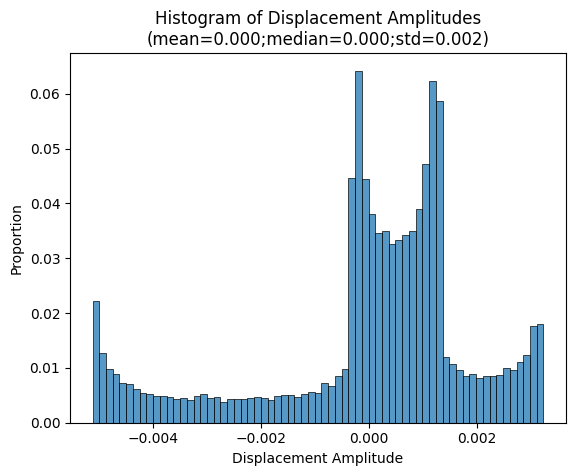

In [75]:
ax = sns.histplot(payload['disp_amp'], bins='auto', stat='proportion')
ax.set_xlabel("Displacement Amplitude")
ax.set_ylabel("Proportion")
stat_ = ";".join([
    f'mean={np.mean(payload["disp_amp"]):.3f}',
    f'median={np.median(payload["disp_amp"]):.3f}',
    f'std={np.std(payload["disp_amp"]):.3f}']
)
ax.set_title(f"Histogram of Displacement Amplitudes\n({stat_})")
plt.show()

In [ ]:
with PolyscopeSession() as ps_session:
	ps_gt_mesh = ps_session.register(ps.register_surface_mesh("gt_mesh", np.asarray(mesh_gt.vertices), np.asarray(mesh_gt.triangles)))
	ps_gt_mesh.add_vector_quantity("displacement", payload['disp'], defined_on='vertices')
	
	ps_def_mesh = ps_session.register(ps.register_surface_mesh("deform_mesh", np.asarray(deform_mesh.vertices), np.asarray(deform_mesh.triangles)))
	ps.show()

In [ ]:
# version = 'gt'
# print(f"Version : {version.upper()}")
# print(f"sha : {sha}")

# mesh = o3d.io.read_triangle_mesh(str(get_prim_mesh_path(sha, version=version)))
# mesh, _, _ = normalize_mesh_with_transform(mesh)


In [13]:
num_eig_choices = [4, 8, 16]
amp_choices = [0.005, 0.01, 0.015]
mesh = mesh_gt

ps_mesh_list = []
with PolyscopeSession() as ps_session:
	ps_mesh_org = ps_session.register(ps.register_surface_mesh(
			"original_mesh",
			np.asarray(mesh.vertices),
			np.asarray(mesh.triangles),
			enabled=True
	))
	for num_eig, amp in tqdm(itertools.product(num_eig_choices, amp_choices)):
		deform_mesh = spectral_displacement(mesh, num_eig=num_eig, amplitude=amp)
		ps_mesh = ps_session.register(ps.register_surface_mesh(
				f"eig{num_eig}_amp{amp}",
				np.asarray(deform_mesh.vertices),
				np.asarray(deform_mesh.triangles),
				enabled=False
		))
		ps_mesh_list.append(ps_mesh)
	ps.show()



9it [00:31,  3.53s/it]


### Break down

In [ ]:
from src.deformation import _mesh_arrays, build_uniform_laplacian
from scipy.sparse.linalg import eigsh

In [331]:
num_eig = 32
amplitude = 0.01
random_state = np.random.RandomState(42)

# input mesh
mesh = o3d.geometry.TriangleMesh.create_cylinder(resolution=30, split=8)
mesh, _, _ = normalize_mesh_with_transform(mesh)

V, F = _mesh_arrays(mesh)
n = V.shape[0]
L = build_uniform_laplacian(mesh) # (nV, nV)

k = min(num_eig + 1, n - 1)  # +1 to drop the constant mode
# smallest eigenvalues (smoothest)
eigvals, eigvecs = eigsh(L, k=k, which="SM") # find k smallest eigenvalues and eigenvectors of the Laplacian L
												# i.e. solve L * v = lambda * v for the smallest lambda(s)
												# each eigenvec of shape (nV, ) is a scalar function defined on at all vertices
												# (num_eig + 1, ), (nV, num_eig + 1)

# drop constant eigenvector (eigval ~ 0)
idx_sorted = np.argsort(eigvals)     # (num_eig + 1, )
eigvals = eigvals[idx_sorted]        # (num_eig + 1, )
eigvecs = eigvecs[:, idx_sorted]     # (nV, num_eig + 1)
eigvecs = eigvecs[:, 1:num_eig + 1]  # skip first, shape (nV, num_eig)

# compute displacements
coeffs = random_state.randn(eigvecs.shape[1]) # (num_eig, )
field = eigvecs @ coeffs                      # (nV, ), this operation combines eigenvectors linearly, i.e. a weighted sum
print(f"[INFO] field before normalization: mean={field.mean():.6f}, std={field.std():.6f}")
field = (field - field.mean()) / (field.std() + 1e-8)

normals = np.asarray(mesh.vertex_normals)
disp = amplitude * field[:, None] * normals

print_tensor(eigvals, 'eigvals')
print_tensor(eigvecs, 'eigvecs')
print_tensor(field, 'field')

[INFO] field before normalization: mean=-0.000000, std=0.322817
eigvals              : (33,), min : 0.000, max : 2.241, mean : 1.200, std : 0.647
eigvecs              : (272, 32), min : -0.114, max : 0.114, mean : 0.000, std : 0.061
field                : (272,), min : -2.355, max : 2.845, mean : -0.000, std : 1.000


In [336]:
# # Visualize modes using heatmap on mesh
# with PolyscopeSession() as ps_session:
# 	ps_mesh = ps_session.register(ps.register_surface_mesh("mesh", np.asarray(mesh.vertices), np.asarray(mesh.triangles)))

# 	vminmax = (eigvecs.min(), eigvecs.max())
# 	for mode_ix in range(0, eigvecs.shape[1], 4):
# 		mode = eigvecs[:, mode_ix]  # (nV, )
# 		# mode_norm = (mode - mode.min()) / (mode.max() - mode.min() + 1e-12)
# 		# vert_colors = plt.get_cmap('jet')(mode_norm)[:, :3]  # (nV, 3)
# 		# ps_mesh.add_color_quantity(f"mode_{mode_ix}", vert_colors, defined_on='vertices')

# 		ps_mesh.add_scalar_quantity(f"mode_{mode_ix}", mode, defined_on='vertices', cmap='jet', vminmax=vminmax)

# 	ps.show()

### Visualize the displacement field
with PolyscopeSession() as ps_session:
	ps_mesh = ps_session.register(ps.register_surface_mesh("mesh", np.asarray(mesh.vertices), np.asarray(mesh.triangles)))
	ps_mesh.add_vector_quantity("displacement", disp, length=0.2)
	
	# ps_verts = ps_session.register(ps.register_point_cloud("displacement_field", np.asarray(mesh.vertices)))
	# ps_verts.add_vector_quantity("displacement", disp)
	
	ps.show()


## Plane deformation

In [295]:
from src.deformation import perturb_planes
from copy import deepcopy

def create_and_normalize_box_mesh(n_iters=3):
	mesh = o3d.geometry.TriangleMesh.create_box()
	print(f"[INFO] Created box mesh with {len(np.asarray(mesh.vertices))} vertices and {len(np.asarray(mesh.triangles))} triangles")
	mesh = mesh.subdivide_midpoint(number_of_iterations=n_iters)
	print(f"[INFO] Subdivided box mesh to {len(np.asarray(mesh.vertices))} vertices and {len(np.asarray(mesh.triangles))} triangles")
	mesh, _, _ = normalize_mesh_with_transform(mesh)
	print(f"[INFO] Normalized box mesh to fit in diag-unit cube centered at origin")
	return mesh

In [293]:


amp_choices = [0.01, 0.05, 0.1]

mesh = create_and_normalize_box_mesh(n_iters=4)
plane_label = 0
face_labels = np.full(len(np.asarray(mesh.triangles)), plane_label)


with PolyscopeSession() as ps_session:
	ps_mesh_org = ps_session.register(ps.register_surface_mesh(
			"original_mesh",
			np.asarray(mesh.vertices),
			np.asarray(mesh.triangles),
			enabled=True
	))

	for amplitude in amp_choices:
		deform_mesh = perturb_planes(
			mesh,
			face_labels,
			plane_label=plane_label,
			amplitude=amplitude,
			freq_u=2,
			freq_v=2
		)
		ps_mesh_deform = ps_session.register(ps.register_surface_mesh(
				f"deformed_mesh(amp={amplitude})",
				np.asarray(deform_mesh.vertices),
				np.asarray(deform_mesh.triangles),
				enabled=False
	))
	ps.show()

[INFO] Created box mesh with 8 vertices and 12 triangles
[INFO] Subdivided box mesh to 1538 vertices and 3072 triangles
[INFO] Normalized box mesh to fit in diag-unit cube centered at origin


### Break Down

In [321]:
mesh = create_and_normalize_box_mesh(n_iters=4)
plane_label = 0
freq_u, freq_v = 2, 2
amplitude = 0.01
face_labels = np.full(len(np.asarray(mesh.triangles)), plane_label)


V, F = _mesh_arrays(mesh)
assert face_labels.shape[0] == F.shape[0]
mesh = deepcopy(mesh)
mesh.compute_vertex_normals()
normals = np.asarray(mesh.vertex_normals)

plane_faces = np.where(face_labels == plane_label)[0]

vert_mask = np.zeros(V.shape[0], dtype=bool)
vert_mask[F[plane_faces].ravel()] = True
verts_plane = V[vert_mask]

# PCA to get dominant plane (u, v, n)
centroid = verts_plane.mean(axis=0)
X = verts_plane - centroid						# shape (n_plane_verts, 3)
u, s, vh = np.linalg.svd(X, full_matrices=False)
basis = vh  # rows: principal directions
# n = basis[2]  # but we already have vertex normals; use them for per-vertex displacement
uv = X @ basis[:2].T  # (n_plane_verts, 2), this gives coordinates in local plane basis

u_coord = uv[:, 0]
v_coord = uv[:, 1]
u_norm = (u_coord - u_coord.min()) / (u_coord.ptp() + 1e-8)
v_norm = (v_coord - v_coord.min()) / (v_coord.ptp() + 1e-8)

height = amplitude * np.sin(freq_u * 2 * np.pi * u_norm)  * np.sin(freq_v * 2 * np.pi * v_norm)

# apply along normals for these vertices
idx_plane_verts = np.where(vert_mask)[0]
disp = np.zeros_like(V)
disp[idx_plane_verts] = height[:, None] * normals[idx_plane_verts]

V_new = V + disp

[INFO] Created box mesh with 8 vertices and 12 triangles
[INFO] Subdivided box mesh to 1538 vertices and 3072 triangles
[INFO] Normalized box mesh to fit in diag-unit cube centered at origin


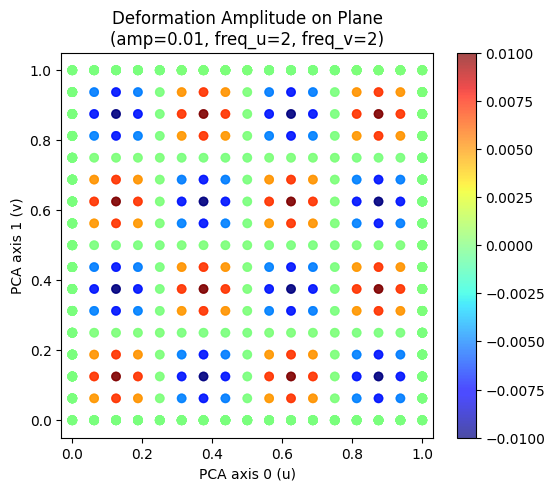

In [323]:
plt.figure(figsize=(6, 5))
plt.scatter(u_norm, v_norm, c=height, cmap='jet', alpha=0.7)
plt.xlabel('PCA axis 0 (u)')
plt.ylabel('PCA axis 1 (v)')
plt.title(f'Deformation Amplitude on Plane\n(amp={amplitude}, freq_u={freq_u}, freq_v={freq_v})')
plt.axis('equal')
plt.colorbar()
plt.show()

In [329]:
with PolyscopeSession() as ps_session:
	ps_plane_verts_pcd = ps_session.register(ps.register_point_cloud(
		"plane_verts",
		np.asarray(verts_plane)
	))
	ps_plane_verts_pcd.add_vector_quantity(
		"displacement_vectors",
		disp[vert_mask],	)

	ps_uv_pcd = ps_session.register(ps.register_point_cloud(
		"uv_coords",
		np.asarray(uv)
	))

	ps.show()

## One go

In [74]:
# 3) Generate trellis-like version
kwargs = {
    'spectral_amp'      : 0.01 * 10,
    'plane_amp'         : 0.01 * 10,
    'cyl_radius_amp'    : 0.02,
    'cyl_wobble_amp'    : 0.02,
    'jitter_scale'      : 0.0005,
    'subdiv_iterations' : 2,
}
mesh_trellis = trellis_like_deform(mesh_o3d, face_labels=tri_prim_labels, **kwargs)

In [69]:
# o3d.io.write_triangle_mesh("./mesh_o3d.ply", mesh_o3d)

In [75]:
# save the trellis mesh
o3d.io.write_triangle_mesh("./trellis_like_mesh.ply", mesh_trellis)


True